# Cluster classifier FIP
Author: Jess Ewald

Thus far we have been comparing the mean classifier signatures. Here, we cluster the FIP for each classifer and annotate with comparison type and F1 score. Hopefully we can learn what good and bad classifiers look like.

In [130]:
# Imports
import polars as pl
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define data paths
result_dir = f"/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results"

batch = "Rep_Ctrls_scen4"
feature_sets = ["non_protein", "protein", "brightfield"]


In [148]:
def process_F1(classification_dir):
    # Read in all F1 score and plot
    comparisons = [
        "REF_control_f1score",
        "VAR_control_f1score",
        "NULL_control_f1score",
        "f1score",
    ]
    comp_dict = {
        "REF_control_f1score": "REF_REF",
        "VAR_control_f1score": "VAR_VAR",
        "NULL_control_f1score": "NULL",
        "f1score": "REF_VAR",
    }

    f1_score = pl.DataFrame()
    for fs in feature_sets:
        for comp in comparisons:

            df = pl.read_csv(
                f"{classification_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
            )

            if "Reference_Well" in df.columns:
                df = df.rename(
                    {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
                )

            df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
                pl.lit(fs).alias("Feature_Set"),
                pl.lit(comp_dict[comp]).alias("Comparison"),
                pl.lit(batch).alias("Batch"),
            )
            f1_score = pl.concat([f1_score, df], how="vertical")
            
    f1_score = f1_score.with_columns(pl.concat_str([pl.col("Comparison"), pl.col("Well_One"), pl.col("Well_Two")], separator="_").alias("Classifer_ID"))
    return f1_score


def process_FIP(classification_dir):
    # Read in all variable feature importance scores

    comparisons = [
        "REF_control_feat_importance",
        "VAR_control_feat_importance",
        "NULL_control_feat_importance",
        "feat_importance",
    ]
    comp_dict = {
        "REF_control_feat_importance": "REF_REF",
        "VAR_control_feat_importance": "VAR_VAR",
        "NULL_control_feat_importance": "NULL",
        "feat_importance": "REF_VAR",
    }

    feat_imp = pl.DataFrame()
    for fs in feature_sets:
        for comp in comparisons:

            df = pl.read_csv(
                f"{classification_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
            )

            if "Reference_Well" in df.columns:
                df = df.rename(
                    {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
                )

            df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
                pl.lit(fs).alias("Feature_Set"),
                pl.lit(comp_dict[comp]).alias("Comparison"),
                pl.lit(batch).alias("Batch"),
            )
            feat_imp = pl.concat([feat_imp, df], how="vertical")
    
    feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Comparison"), pl.col("Well_One"), pl.col("Well_Two")], separator="_").alias("Classifer_ID"))
    return feat_imp


def plot_heatmap(feature, fip_df, f1_df, norm_row=False, norm_col=False):
    
    fip_df = fip_df.filter((pl.col("Feature_Set") == feature)).sort(pl.col("Classifer_ID"))
    f1_df = f1_df.filter((pl.col("Feature_Set") == feature) &
                         (pl.col("variable") == "F1_Score")).sort(pl.col("Classifer_ID")).to_pandas()

    fip_df = fip_df.to_pandas().pivot(index=["Classifer_ID", "Comparison"], columns="variable", values="value")
    
    # get colors corresponding to comparison type
    comps = [row[1] for row in list(fip_df.index)]
    lut = dict(zip(['NULL', 'VAR_VAR', 'REF_REF', 'REF_VAR'], "yrbg"))
    comp_colors = [lut[item] for item in comps]
    
    # get colors corresponding to F1 score
    cmap = sns.color_palette("viridis", as_cmap=True)
    f1_colors = f1_df['value'].map(lambda x: cmap(x))
    
    row_colors = pd.DataFrame({"Comparison": comp_colors, "F1_Score": f1_colors})
    
    if norm_row:
        fip_df.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    
    if norm_col:
        fip_df = (fip_df-fip_df.mean())/fip_df.std()

    plt.figure(figsize = (16,5))
    sns.clustermap(fip_df.reset_index(drop=True), square=True, norm=LogNorm(), row_colors=row_colors, 
                   cbar_pos=None, yticklabels=False, xticklabels=False)

In [151]:
# Rep_Ctrls_scen4_B6_ALK_30Apr2024
# Rep_Ctrls_scen4_B6_MAPK_LPAR1_30Apr2024

run_nm = "Rep_Ctrls_scen4_B6_MAPK_LPAR1_30Apr2024"

# ALK WT-VAR
f1_alk = process_F1(f"{result_dir}/Rep_Ctrls_scen4_B6_ALK_30Apr2024")
fip_alk = process_FIP(f"{result_dir}/Rep_Ctrls_scen4_B6_ALK_30Apr2024")

f1_mapk9 = process_F1(f"{result_dir}/Rep_Ctrls_scen4_B6_MAPK_LPAR1_30Apr2024")
fip_mapk9 = process_FIP(f"{result_dir}/Rep_Ctrls_scen4_B6_MAPK_LPAR1_30Apr2024")


<Figure size 1600x500 with 0 Axes>

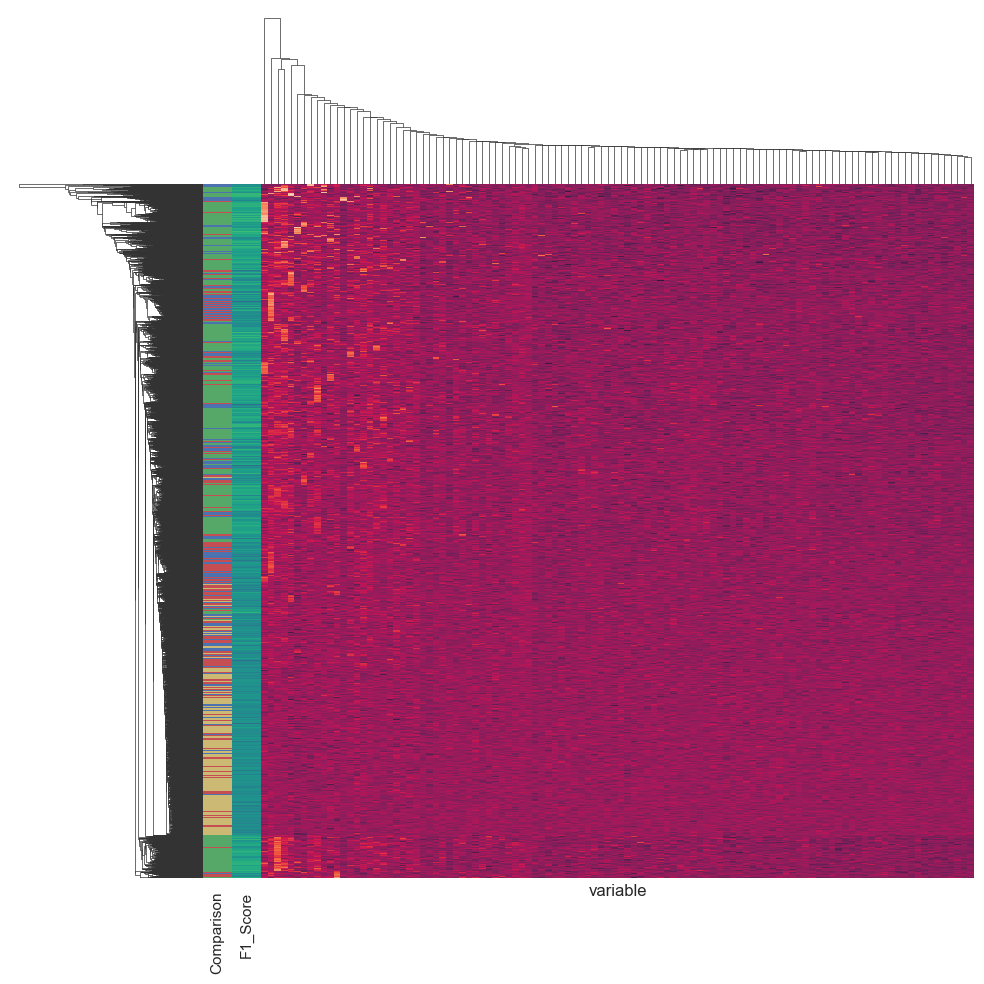

In [154]:
plot_heatmap("protein", fip_alk, f1_alk)

<Figure size 1600x500 with 0 Axes>

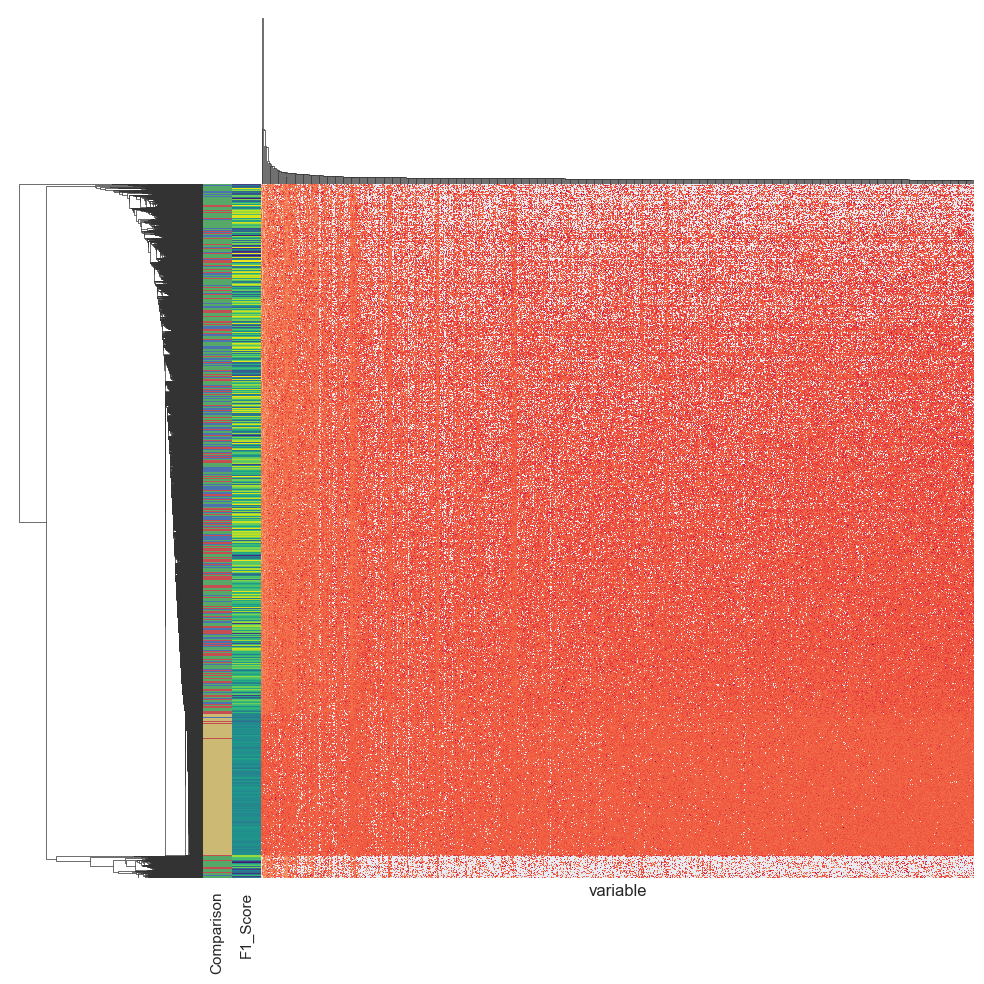

In [155]:
plot_heatmap("non_protein", fip_alk, f1_alk)

<Figure size 1600x500 with 0 Axes>

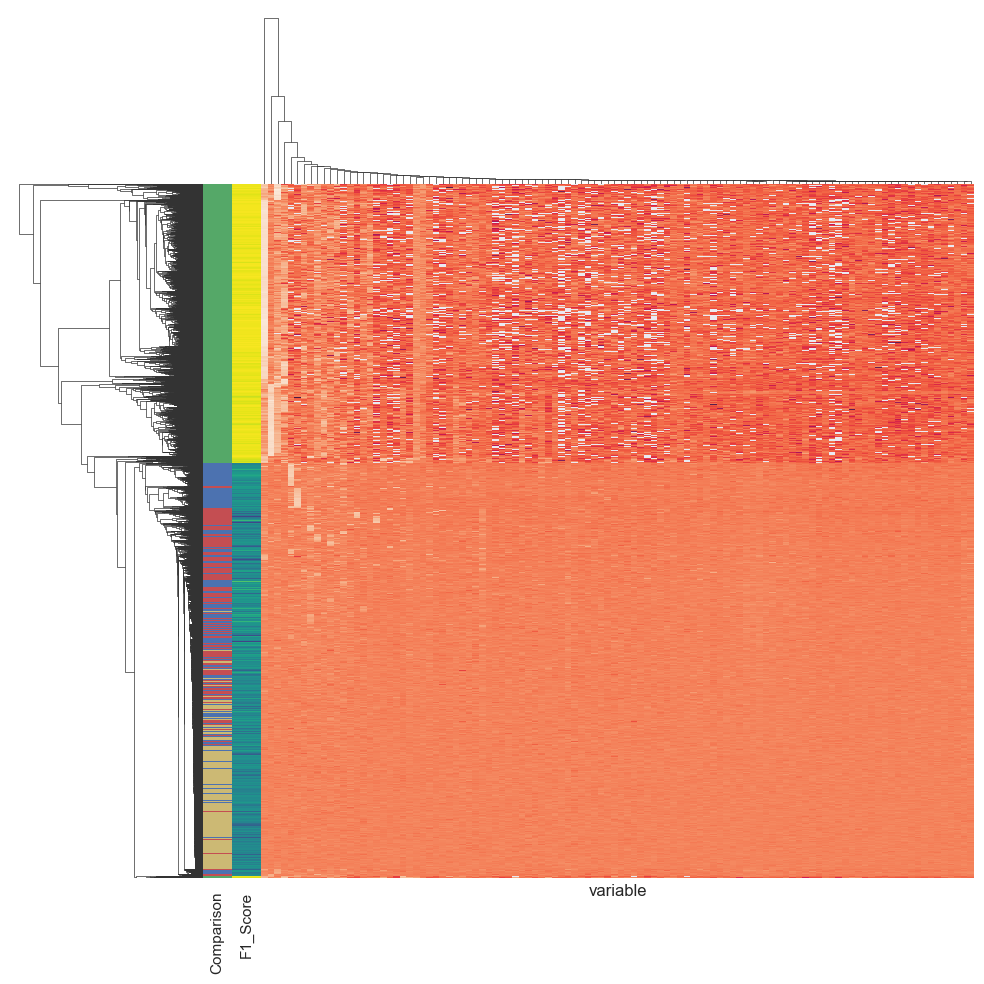

In [152]:
plot_heatmap("protein", fip_mapk9, f1_mapk9)

<Figure size 1600x500 with 0 Axes>

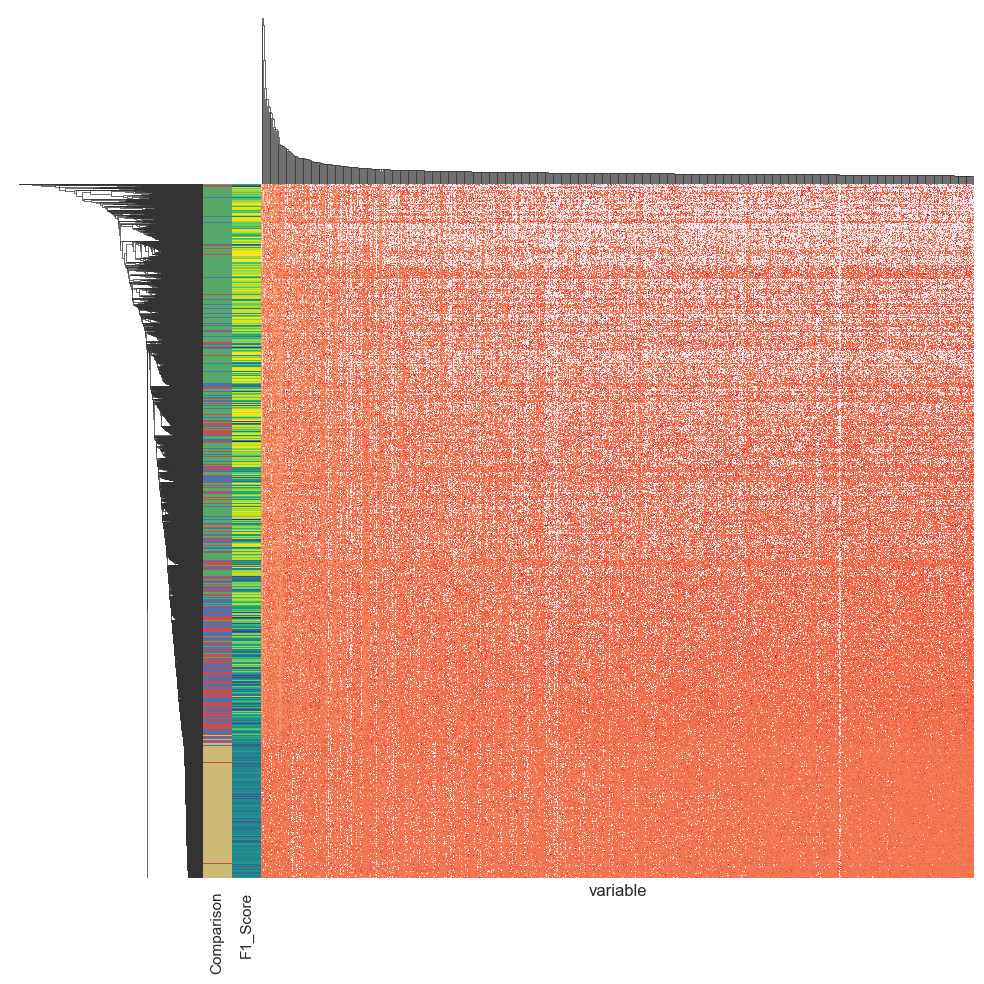

In [153]:
plot_heatmap("non_protein", fip_mapk9, f1_mapk9)